In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans
from sklearn.metrics import (mean_absolute_error,mean_squared_error,
                             r2_score,confusion_matrix,accuracy_score)

In [5]:
df = pd.read_csv(r"C:\Users\Hanumanthu Yugandhar\Downloads\Air_Quality.csv")
df.head()

,Unique ID,Indicator ID,Name,Measure,Measure Info,Geo Type Name,Geo Join ID,Geo Place Name,Time Period,Start_Date,Data Value,Message
0,336867,375,Nitrogen dioxide (NO2),Mean,ppb,CD,407,Flushing and Whitestone (CD7),Winter 2014-15,12/01/2014,23.97,NaN
1,336741,375,Nitrogen dioxide (NO2),Mean,ppb,CD,107,Upper West Side (CD7),Winter 2014-15,12/01/2014,27.42,NaN
2,550157,375,Nitrogen dioxide (NO2),Mean,ppb,CD,414,Rockaway and Broad Channel (CD14),Annual Average 2017,01/01/2017,12.55,NaN
3,412802,375,Nitrogen dioxide (NO2),Mean,ppb,CD,407,Flushing and Whitestone (CD7),Winter 2015-16,12/01/2015,22.63,NaN
4,412803,375,Nitrogen dioxide (NO2),Mean,ppb,CD,407,Flushing and Whitestone (CD7),Summer 2016,06/01/2016,14.00,NaN


In [6]:
print("Dataset Shape:", df.shape)
print("\nFirst 5 Rows:\n", df.head())
print("\nDataset Info:")
print(df.info())
print("\nNull Values Before Cleaning:\n", df.isnull().sum())

Dataset Shape: (18862, 12)

First 5 Rows:
    Unique ID  Indicator ID                    Name Measure Measure Info  \
0     336867           375  Nitrogen dioxide (NO2)    Mean          ppb   
1     336741           375  Nitrogen dioxide (NO2)    Mean          ppb   
2     550157           375  Nitrogen dioxide (NO2)    Mean          ppb   
3     412802           375  Nitrogen dioxide (NO2)    Mean          ppb   
4     412803           375  Nitrogen dioxide (NO2)    Mean          ppb   

  Geo Type Name  Geo Join ID                     Geo Place Name  \
0            CD          407      Flushing and Whitestone (CD7)   
1            CD          107              Upper West Side (CD7)   
2            CD          414  Rockaway and Broad Channel (CD14)   
3            CD          407      Flushing and Whitestone (CD7)   
4            CD          407      Flushing and Whitestone (CD7)   

           Time Period  Start_Date  Data Value  Message  
0       Winter 2014-15  12/01/2014       23.9

# OBJECTIVE : DATA CLEANING & PREPROCESSING

In [7]:
df['Message'] = df['Message'].fillna("No Message")
df['Data Value'] = df['Data Value'].fillna(df['Data Value'].median())
df['Start_Date'] = pd.to_datetime(df['Start_Date'], errors='coerce')
df['Year'] = df['Start_Date'].dt.year
df['Month'] = df['Start_Date'].dt.month
def get_season(x):
    x = str(x).lower()
    if 'winter' in x: return 'Winter'
    if 'summer' in x: return 'Summer'
    if 'spring' in x: return 'Spring'
    if 'fall' in x: return 'Fall'
    return 'Annual'

df['Season'] = df['Time Period'].apply(get_season)
df = df.dropna(subset=['Year', 'Month', 'Data Value'])

print("\nNull Values After Cleaning:\n", df.isnull().sum())
print("Final Dataset Shape:", df.shape)


Null Values After Cleaning:
 Unique ID         0
Indicator ID      0
Name              0
Measure           0
Measure Info      0
Geo Type Name     0
Geo Join ID       0
Geo Place Name    0
Time Period       0
Start_Date        0
Data Value        0
Message           0
Year              0
Month             0
Season            0
dtype: int64
Final Dataset Shape: (18862, 15)


# OBJECTIVE : EXPLORATORY DATA ANALYSIS (EDA)


EDA Summary of Pollution Values:
count    18862.000000
mean        21.051580
std         23.564920
min          0.000000
25%          8.742004
50%         14.790000
75%         26.267500
max        424.700000
Name: Data Value, dtype: float64


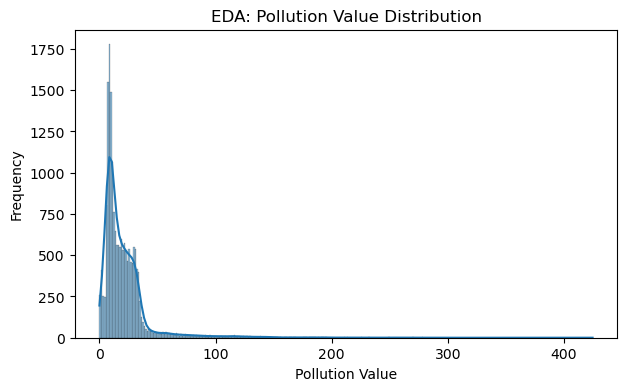

In [8]:
print("\nEDA Summary of Pollution Values:")
print(df['Data Value'].describe())

plt.figure(figsize=(7,4))
sns.histplot(df['Data Value'], kde=True)
plt.title("EDA: Pollution Value Distribution")
plt.xlabel("Pollution Value")
plt.ylabel("Frequency")
plt.show()
X = df[['Name', 'Geo Type Name', 'Geo Place Name',
        'Season', 'Year', 'Month']]
y = df['Data Value']
ct = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'),
     ['Name', 'Geo Type Name', 'Geo Place Name', 'Season'])], remainder='passthrough')

# OBJECTIVE : REGRESSION (RANDOM FOREST)


Regression Results:
MAE : 3.712139828295516
RMSE: 11.976038395640353
R2  : 0.776304413118212


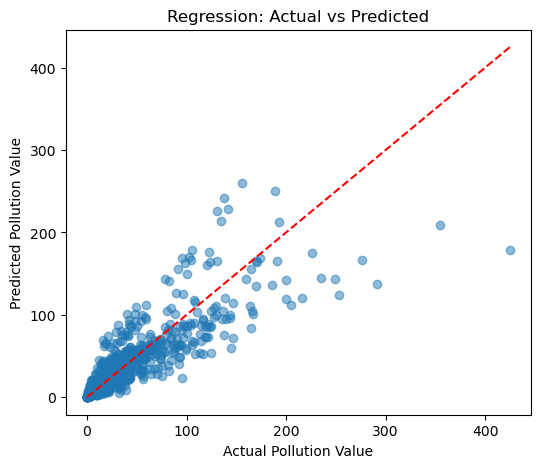

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
reg_model = Pipeline([
    ('preprocess', ct),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])
reg_model.fit(X_train, y_train)
y_pred = reg_model.predict(X_test)

print("\nRegression Results:")
print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2  :", r2_score(y_test, y_pred))

plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Pollution Value")
plt.ylabel("Predicted Pollution Value")
plt.title("Regression: Actual vs Predicted")
plt.show()

# OBJECTIVE : CLASSIFICATION (KNN ONLY)


KNN Classification Results:
Accuracy: 0.8436257619931089
Confusion Matrix:
 [[1115  111   50]
 [ 130  926  181]
 [  14  104 1142]]


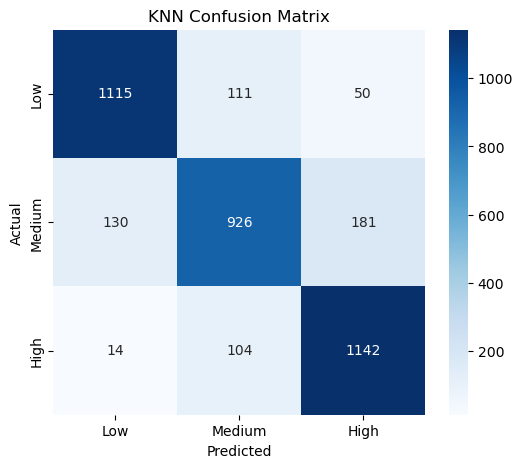

In [11]:
df['Pollution_Level'] = pd.qcut(
    df['Data Value'], 3, labels=['Low', 'Medium', 'High']
)
y_clf = df['Pollution_Level']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X, y_clf, test_size=0.2, random_state=42
)

knn_model = Pipeline([
    ('preprocess', ct),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

knn_model.fit(X_train_c, y_train_c)
y_pred_knn = knn_model.predict(X_test_c)

acc_knn = accuracy_score(y_test_c, y_pred_knn)
cm_knn = confusion_matrix(
    y_test_c, y_pred_knn,
    labels=['Low', 'Medium', 'High']
)

print("\nKNN Classification Results:")
print("Accuracy:", acc_knn)
print("Confusion Matrix:\n", cm_knn)

plt.figure(figsize=(6,5))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# DECISION TREE (ONLY VISUALIZATION – NO CLASSIFICATION)

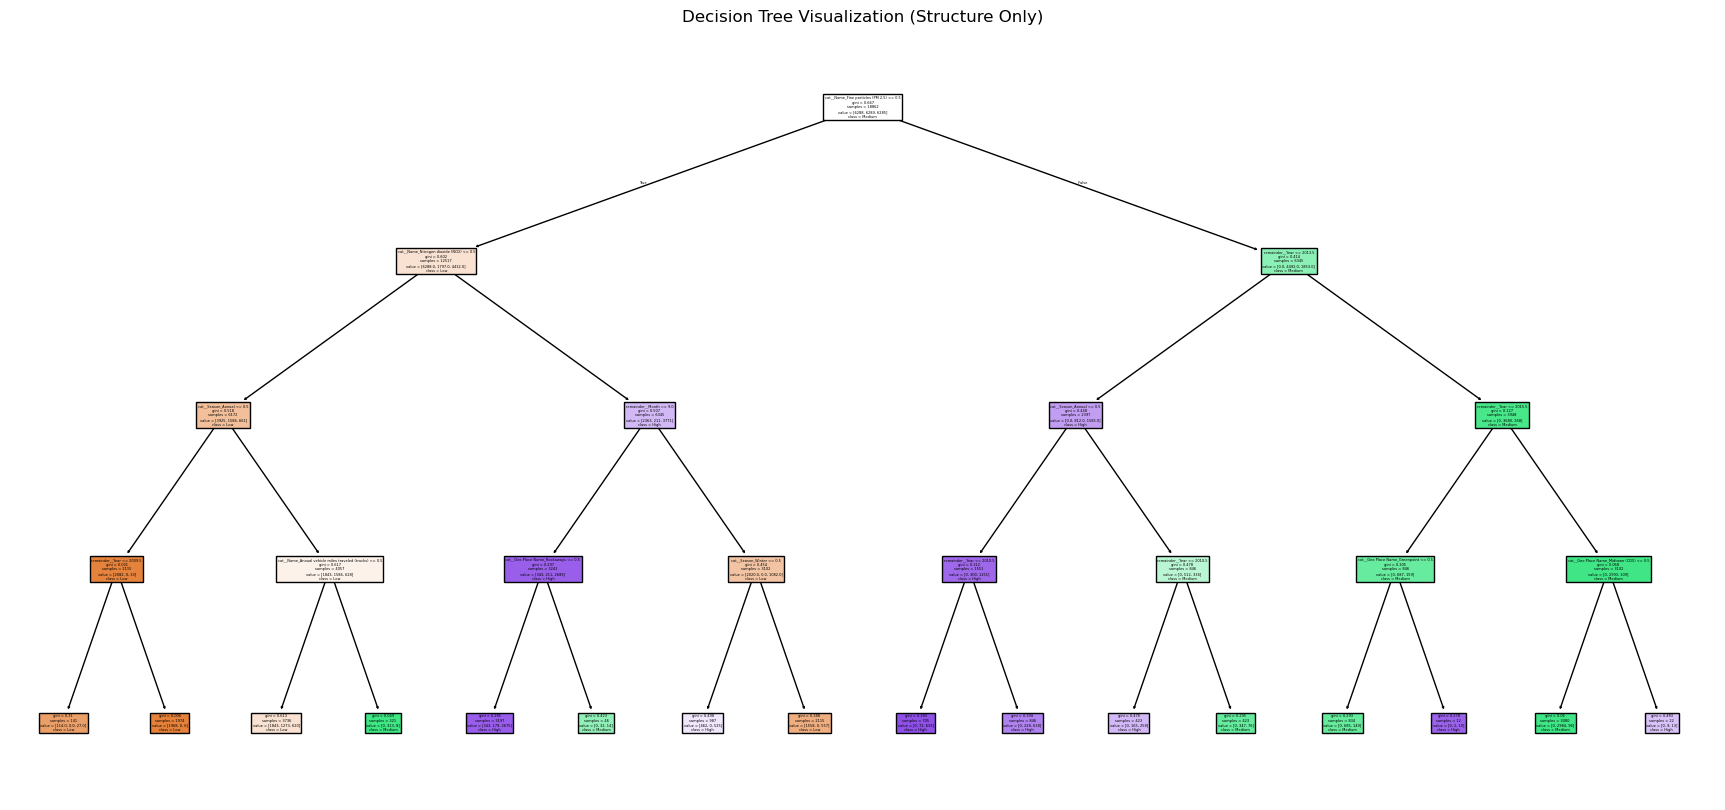

In [12]:
dt_visual = Pipeline([
    ('preprocess', ct),
    ('classifier', DecisionTreeClassifier(
        max_depth=4, random_state=42))
])

dt_visual.fit(X, y_clf)

dt_clf = dt_visual.named_steps['classifier']
feature_names = dt_visual.named_steps[
    'preprocess'].get_feature_names_out()

plt.figure(figsize=(22,10))
plot_tree(
    dt_clf,
    feature_names=feature_names,
    class_names=['Low', 'Medium', 'High'],
    filled=True
)
plt.title("Decision Tree Visualization (Structure Only)")
plt.show()

# OBJECTIVE : CORELATION

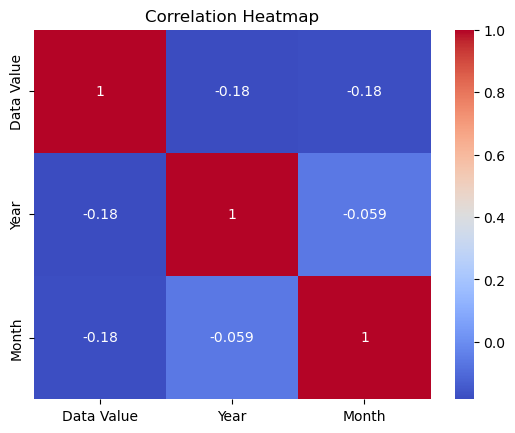

In [13]:
corr = df[['Data Value','Year','Month']].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# OBJECTIVE : CLUSTERING (K-MEANS)


Clustering Results:
Cluster Centers:
 [[  32.13624141 2013.76848928]
 [ 127.54838729 2011.2919708 ]
 [  10.88189185 2015.33764333]]


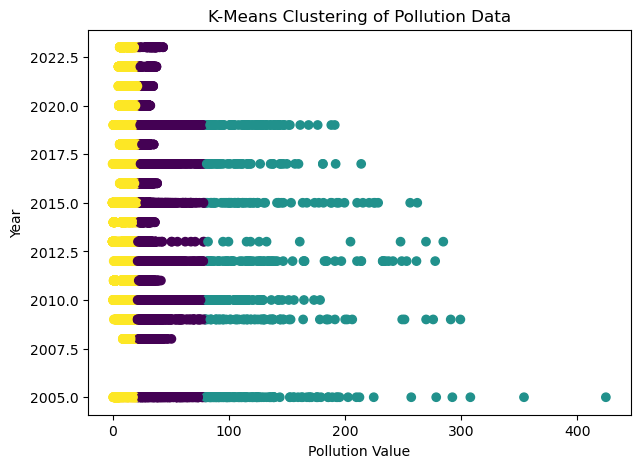

In [15]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
cluster_data = df[['Data Value', 'Year']]

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(cluster_data)

print("\nClustering Results:")
print("Cluster Centers:\n", kmeans.cluster_centers_)

plt.figure(figsize=(7,5))
plt.scatter(cluster_data['Data Value'],
            cluster_data['Year'],
            c=df['Cluster'])
plt.xlabel("Pollution Value")
plt.ylabel("Year")
plt.title("K-Means Clustering of Pollution Data")
plt.show()